In [1]:
import pytumblr
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import re
import nltk.data
import logging
from gensim.models import word2vec
from sklearn.kernel_approximation import RBFSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from time import time

import matplotlib.pyplot as plt
%matplotlib inline

## Tumblr data scraping

In [2]:
# Authenticate via OAuth
client = pytumblr.TumblrRestClient(
  'IfgCzO5vai28fvtoOZqhirNO4Wy4XWDEBAB0iORxfCCxcpqfky',
  'c7NCLElazxRkIUgZw00Ur5lW6qsL2SR8qmVdQ3jyd29RkoeGB3',
  '4z8Ljx4lc2YJkh5rCf6dEWAGs9A4M0Z7EQFL7jVH4AnDBeCd69',
  'JTHBUNxnSoK5VcB7nHipx7rSYbMGilW27DceHVhu9lI0z0Law1'
)

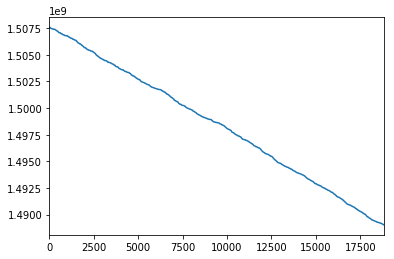

In [7]:
# 6 basic emotions: happiness, sadness, anger, disgust, fear, surprise
# Posts available here: https://www.tumblr.com/tagged/happy
# More emotions here: https://upload.wikimedia.org/wikipedia/commons/c/ce/Plutchik-wheel.svg
search_query = 'excited'
old_queries = set(['happy', 'sad', 'angry', 'disgusted', 'scared', 'surprised',
                   'amazed', 'bored', 'pensive', 'annoyed', 'interested', 'optimistic',
                   'love', 'ashamed', 'calm', 'excited'])

if (search_query in old_queries):
    new_search = False
else:
    new_search = True

if (not new_search):
    # Load previously scraped data
    df = pd.read_csv('./data/' + search_query + '.csv', encoding='utf-8')
    df['timestamp'].plot()
    plt.show()

In [8]:
t0 = time()

posts = []

if (not new_search):
    # Continue scraping starting from the oldest timestamp
    before = df['timestamp'].min()
else:
    before = (int)(t0)

# Delta limit in timestamps between two consecutive posts
not_common_queries = set(['surprised', 'amazed', 'pensive', 'annoyed', 'interested',
                          'optimistic', 'ashamed', 'calm', 'excited'])
if (search_query in not_common_queries):
    delta_limit = 3600 * 24 * 3 # 3 days for 'surprised', 'amazed', 'annoyed', 'calm', 'excited'
                                #7 for 'pensive', 'interested', 'optimistic', 'ashamed'
else:
    delta_limit = 3600 * 24 # 1 day
nb_rejected = 0
timestamps_rejected = []

# 960 requests to avoid exceeding Tumblr API's limitations
for i in range(960):
    tagged = client.tagged(search_query, filter='text', before=before)
    for elt in tagged:
        timestamp = elt['timestamp']
        if (abs(timestamp - before) < delta_limit):
            before = timestamp
            
            current_post = []
            current_post.append(elt['id'])
            current_post.append(elt['post_url'])

            elt_type = elt['type']
            current_post.append(elt_type)
            current_post.append(timestamp)
            current_post.append(elt['date'])
            current_post.append(elt['tags'])
            current_post.append(elt['liked'])
            current_post.append(elt['note_count'])

            if (elt_type == 'photo'):
                # Only take the first image
                current_post.append(elt['photos'][0]['original_size']['url'])
                current_post.append(elt['caption'].replace('\n',' ').replace('\r',' '))
                current_post.append(search_query)
                posts.append(current_post)
            elif (elt_type == 'text'):
                current_post.append(np.nan)
                current_post.append(elt['body'].replace('\n',' ').replace('\r',' '))
                current_post.append(search_query)
                posts.append(current_post)
        else:
            nb_rejected += 1
            timestamps_rejected.append(timestamp)
    
print('Rejected {0} posts'.format(nb_rejected))
print(timestamps_rejected)
print('The scraping took {0}s'.format(time() - t0))

Rejected 3 posts
[1462761483, 1466958075, 1389089224]
The scraping took 1031.98695302s


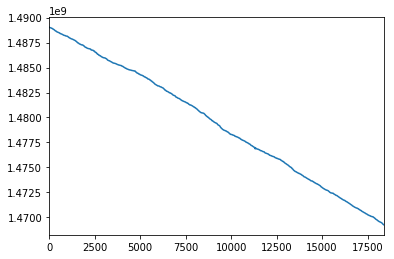

In [9]:
df_posts = pd.DataFrame(posts, columns=['id', 'post_url', 'type', 'timestamp', 'date',
                                        'tags', 'liked', 'note_count', 'photo', 'text', 'search_query'])
df_posts['timestamp'].plot()
plt.show()

In [10]:
if (not new_search):
    # Concatenate and save the new posts
    df_concat = pd.concat([df, df_posts]).reset_index(drop=True)
    df_concat.to_csv('./data/' + search_query + '.csv', encoding='utf-8', index=False)
else:
    df_posts.to_csv('./data/' + search_query + '.csv', encoding='utf-8', index=False)

In [ ]:
import numpy as np

def extract_tumblr_posts(client, nb_requests, search_query, before, delta_limit):
    """Extract Tumblr posts with a given emotion.
    
    Parameters:
        client: Authenticated Tumblr client with the pytumblr package.
        nb_requests: Number of API request.
        search_query: Emotion to search for.
        before: A timestamp to search for posts before that value.
        delta_limit: Maximum difference of timestamp between two queries.
    """    
    for i in range(nb_requests):
        tagged = client.tagged(search_query, filter='text', before=before)
        nb_rejected = 0
        timestamps_rejected = []
        for elt in tagged:
            timestamp = elt['timestamp']
            if (abs(timestamp - before) < delta_limit):
                before = timestamp

                current_post = []
                current_post.append(elt['id'])
                current_post.append(elt['post_url'])

                elt_type = elt['type']
                current_post.append(elt_type)
                current_post.append(timestamp)
                current_post.append(elt['date'])
                current_post.append(elt['tags'])
                current_post.append(elt['liked'])
                current_post.append(elt['note_count'])

                if (elt_type == 'photo'):
                    # Only take the first image
                    current_post.append(elt['photos'][0]['original_size']['url'])
                    current_post.append(elt['caption'].replace('\n',' ').replace('\r',' '))
                    current_post.append(search_query)
                    posts.append(current_post)
                elif (elt_type == 'text'):
                    current_post.append(np.nan)
                    current_post.append(elt['body'].replace('\n',' ').replace('\r',' '))
                    current_post.append(search_query)
                    posts.append(current_post)
            else:
                nb_rejected += 1
                timestamps_rejected.append(timestamp)

            return (posts, nb_rejected, timestamps_rejected)

## Word2vec

In [2]:
df_happy = pd.read_csv('./data/happy.csv', encoding='utf-8')

In [3]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [4]:
# Convert a sentence to a list of words
def sentence_to_wordlist(sentence):
    # Remove HTML
    sentence_text = BeautifulSoup(sentence).get_text()
    # Remove non-letters
    sentence_text = re.sub('[^a-zA-Z]', ' ', sentence_text)
    # Convert words to lower case and split them
    words = sentence_text.lower().split()
    return words

# Break a paragraph into sentences thanks to a tokenizer,
# then break each sentences into list of words
# Used to train Word2Vec
def paragraph_to_words(paragraph, tokenizer):
    sentences = []
    # Check for nan text
    if (type(paragraph) == float) and (np.isnan(paragraph)):
        pass
    else:
        raw_sentences = tokenizer.tokenize(paragraph.strip())
        for elt in raw_sentences:
            if (len(elt) > 0):
                sentences.append(sentence_to_wordlist(elt))
    return sentences

# Once the model is trained, convert a paragraph into a matrix in
# the Word2Vec space
def paragraph_to_words_repr(paragraph, tokenizer, vocab, vocab_repr):
    sentences = []
    # Check for nan text
    if (type(paragraph) == float) and (np.isnan(paragraph)):
        pass
    else:
        raw_sentences = tokenizer.tokenize(paragraph.strip())
        for elt in raw_sentences:
            if (len(elt) > 0):
                sentences.extend(sentence_to_wordlist(elt))

    words_repr = []
    for elt in sentences:
        if elt in vocab:
            words_repr.append(vocab_repr[elt])
    return np.array(words_repr)

In [5]:
def create_features(X):
    train = X.copy()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    sentences = []

    for text in train['text']:
        sentences += paragraph_to_words(text, tokenizer)
        
    # Import the built-in logging module and configure it so that Word2Vec 
    # creates nice output messages
    #logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    #                    level=logging.INFO)
    
    # Set values for various parameters
    num_features = 300    # Word vector dimensionality                      
    min_word_count = 40   # Minimum word count                        
    num_workers = 4       # Number of threads to run in parallel
    context = 10          # Context window size                                                                                    
    downsampling = 1e-3   # Downsample setting for frequent words

    # Initialize and train the model (this will take some time)
    print "Training model..."
    model = word2vec.Word2Vec(sentences, workers=num_workers,
                              size=num_features, min_count=min_word_count,
                              window=context, sample=downsampling)

    vocab = set(model.wv.vocab.keys())
    words_repr = model.wv

    train['text_list'] = train['text'].map(lambda x: paragraph_to_words_repr(x, tokenizer, vocab, words_repr))
    mask = train['text_list'].map(len) > 0
    train_reduced = train.loc[mask, :].reset_index(drop=True)
    return (train_reduced, model)

In [6]:
# Use only 2 emotions first: happiness and sadness
df_happy = pd.read_csv('./data/happy.csv', encoding='utf-8')
df_sad = pd.read_csv('./data/sad.csv', encoding='utf-8')

# Convert a string representation of a list such as '[happy, sun, outdoors]'
# to an actual set of strings {'happy', 'sun', 'outdoors'}
def str_list_to_set(str_list):
    output = str_list[1:-1].split(',')
    output = set([x.strip() for x in output])
    return output

# Make sure that the relevant hashtag is in the post
df_happy['tags'] = df_happy['tags'].map(str_list_to_set)
mask_happy = df_happy['tags'].map(lambda x: 'happy' in x)
df_happy = df_happy.loc[mask_happy, :].reset_index(drop=True)

df_sad['tags'] = df_sad['tags'].map(str_list_to_set)
mask_sad = df_sad['tags'].map(lambda x: 'sad' in x)
df_sad = df_sad.loc[mask_sad, :].reset_index(drop=True)

In [7]:
df_all = pd.concat([df_happy, df_sad]).reset_index(drop=True)

In [9]:
df_all = df_all[:50]

In [10]:
train, model = create_features(df_all)

# Binarise emotions
emotion_dict = dict(zip(['happy', 'sad'], [1, 0]))
train['search_query'] =  train['search_query'].map(emotion_dict)

//anaconda/envs/tensorflow/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file //anaconda/envs/tensorflow/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))
//anaconda/envs/tensorflow/lib/python2.7/site-packages/bs4/__init__.py:219: UserWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Training model...


In [12]:
model.wv.save_word2vec_format('small_model.bin', binary=True)

In [1]:
import gensim
model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('small_model.bin', binary=True)

In [4]:
model.syn0

array([[  1.65942183e-03,  -5.55102481e-04,  -2.40064954e-04, ...,
          5.73514437e-04,  -1.03433290e-03,   1.64276024e-03],
       [  1.32755353e-03,  -1.52046629e-03,   3.24133616e-05, ...,
          1.60464400e-03,  -5.41558373e-04,   1.03896682e-03],
       [  5.53138052e-05,   8.06477678e-04,   4.04818857e-04, ...,
          1.42612553e-03,   1.42030287e-04,  -2.43251168e-04],
       [ -1.46116261e-04,  -1.94027103e-04,  -1.85558383e-04, ...,
         -1.45258906e-04,   9.35661083e-04,   1.38525607e-03]], dtype=float32)

In [7]:
gensim.__version__

'2.1.0'

## Random Fourier features

In [17]:
train['text_list'][1].shape

(10, 300)

In [18]:
n_components = 400
random_seed = 8
rbf = RBFSampler(gamma=1, n_components=n_components, random_state=random_seed)
for i in range(n_components):
    train['rbf_feature_' + str(i)] = 0
rbf_columns = ['rbf_feature_' + str(i) for i in range(n_components)]
train[rbf_columns] = np.vstack(train['text_list'].map(lambda x: rbf.fit_transform(x).mean(axis=0)))

In [27]:
# Other representation, without RBF
num_features = 300
random_seed = 8
mean_features = ['mean_feature_' + str(i) for i in range(num_features)]
for col in mean_features:
    train[col] = 0
train[mean_features] = np.vstack(train['text_list'].map(lambda x: x.mean(axis=0)))

## Prediction

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train[rbf_columns], train['search_query'], 
                                                    test_size=0.3, random_state=random_seed)
#forest = RandomForestClassifier(max_depth=15, random_state=random_seed)
#forest.fit(X_train, y_train)
log_reg = LogisticRegression(random_state=random_seed)
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
print('Train score: {0}'.format(accuracy_score(y_train_pred, y_train)))
print('Test score: {0}'.format(accuracy_score(y_test_pred, y_test)))

Train score: 0.814135520767
Test score: 0.812481466505


In [28]:
# With mean features
X_train, X_test, y_train, y_test = train_test_split(train[mean_features], train['search_query'], 
                                                    test_size=0.3, random_state=random_seed)
#forest = RandomForestClassifier(max_depth=15, random_state=random_seed)
#forest.fit(X_train, y_train)
log_reg = LogisticRegression(random_state=random_seed)
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
print('Train score: {0}'.format(accuracy_score(y_train_pred, y_train)))
print('Test score: {0}'.format(accuracy_score(y_test_pred, y_test)))

Train score: 0.85882964589
Test score: 0.86019679202


In [38]:
top_coefs = sorted(zip(log_reg.coef_.reshape(-1), np.arange(num_features, dtype=int)), reverse=False)[:20]
top_coefs_indices = [x[1] for x in top_coefs]
top_coefs

[(-2.8827834248291402, 55),
 (-2.8124139227226754, 236),
 (-2.6812655119110405, 24),
 (-2.6762807585959876, 103),
 (-2.6502919228441297, 173),
 (-2.5075418914996517, 137),
 (-2.4911933236573724, 93),
 (-2.4672354382535877, 266),
 (-2.4433347327073891, 119),
 (-2.3788464261661915, 180),
 (-2.3307347663563069, 201),
 (-2.2903054568151471, 283),
 (-2.281914462965593, 32),
 (-2.1232339254045631, 19),
 (-2.0542173388319376, 281),
 (-2.0506230160033136, 174),
 (-2.0014828017009636, 139),
 (-1.9205927423088367, 284),
 (-1.880189952908941, 285),
 (-1.8801101761466934, 254)]

In [39]:
def find_k_most_relevant_word(n_col, vocab, model_repr, k):
    max_coefs = [0] * k
    max_words = [''] * k
    for word in vocab:
        coef = model_repr[word][n_col]
        if (coef > max_coefs[0]):
            max_coefs[1:] = max_coefs[:-1]
            max_coefs[0] = coef
            max_words[1:] = max_words[:-1]
            max_words[0] = word
    return max_words

vocab = model.wv.vocab.keys()
model_repr = model.wv

[find_k_most_relevant_word(i, vocab, model_repr, 5) for i in top_coefs_indices]

[[u'instagood', u'fun', u'picoftheday', u'en', u'instalove'],
 [u'matter', u'reason', u'am', u'summer', u'fix'],
 [u'talk', u'such', u'how', u'quite', u'both'],
 [u'gif', u'people', u'trending', u'music', u'hanging'],
 [u'out', u'these', u'https', u'lot', u'send'],
 [u'wasn', u'beauty', u'fingers', u'bringing', u'hanging'],
 [u'che', u'photooftheday', u'instalike', u'em', u'das'],
 [u'stop', u'things', u'k', u'tired', u'wednesday'],
 [u'gph', u'took', u'in', u'into', u'around'],
 [u'tt', u'o', u'uma', u'lots', u'djale'],
 [u'your', u'away', u'you', u'smile', u'sky'],
 [u'someone', u'stop', u'friend', u'happen', u'start'],
 [u'an', u'such', u'movies', u'ate', u'wine'],
 [u'how', u'tired', u'otra', u'hanging', u'solopreneurs'],
 [u'been', u'talked', u'wasn', u'drinks', u'hanging'],
 [u'mom', u'go', u'came', u'wasn', u'hanging'],
 [u'than', u're', u'funny', u'hot', u'loathing'],
 [u'didn', u'wasn', u'wrong', u'until', u'brought'],
 [u'up', u'be', u'ever', u'mail', u'hold'],
 [u'while', u'

* add more emotions https://upload.wikimedia.org/wikipedia/commons/c/ce/Plutchik-wheel.svg
* multiple emotions for structure of emotions